# Analyse exploratoire du jeu de données BRFSS 2015 — Diabète

Le fichier `diabetes_binary_health_indicators_BRFSS2015.csv` est un jeu de données
on peut lire sur kaggle qu'il est propre ( même si l'on vérifiera ça par la suite)
et contenant **253 680 réponses** à l'enquête BRFSS2015.  
La variable cible `Diabetes_binary` comporte deux classes :  
- `0` : absence de diabète  
- `1` : prédiabète ou diabète.  
Le jeu de données comprend **21 variables explicatives**.


L'on va se servir des objectifs et questions soulevés par les experts qui ont mené cette étude 
afin d'orienter notre approche, leur questions sont les suivantes : 

1) Les questions de l'enquête BRFSS permettent-elles de prédire avec précision si une personne est atteinte de diabète ?

2) Quels sont les facteurs de risque les plus prédictifs du risque de diabète ?

3) Peut-on utiliser un sous-ensemble de facteurs de risque pour prédire avec 
   précision si un individu est atteint de diabète ?

4) Peut-on créer une version abrégée des questions du BRFSS 
   en utilisant la sélection de caractéristiques pour prédire avec précision 
   si une personne est susceptible d'avoir le diabète ou présente un risque élevé de diabète ?"""


### Objectifs de l’étude exploratoire :
1. Visualiser les données.  
2. Étudier les caractéristiques de chaque variable (nom, type).  
3. Examiner les données manquantes.    
4. Évaluer l’utilité des variables pour la tâche de prédiction.  
5. Étudier la corrélation entre les variables.  
6. Proposer d’éventuelles transformations à réaliser.  

---


In [91]:
import matplotlib.pyplot as plt
from pathlib import Path 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### Etape 1 : Visualisation globale et contexte du dataset

In [92]:
## gestion du chemin pour que cela soit portable 
import sys
import os


# Ajoute le dossier racine du projet au path
project_root = Path.cwd().parents[0]  
sys.path.append(str(project_root))

github_path = Path.cwd().parent / "data" / "diabetes_binary_health_indicators_BRFSS2015.csv"
local_path = Path.cwd().parents[1] / "Diabete" / "diabetes_binary_health_indicators_BRFSS2015.csv"

if github_path.exists():
    data_path = github_path
    print(" Fichier trouvé (GitHub structure) :", data_path.resolve())
elif local_path.exists():
    data_path = local_path
    print(" Fichier trouvé (local structure) :", data_path.resolve())
else:
    raise FileNotFoundError(
        " Le fichier CSV est introuvable.\n"
    )



 Fichier trouvé (local structure) : C:\IMT\2A\introML\S2_part2\projetML\Diabete\diabetes_binary_health_indicators_BRFSS2015.csv


Dataset CSV chargé : 253680 lignes, 22 colonnes
   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0     

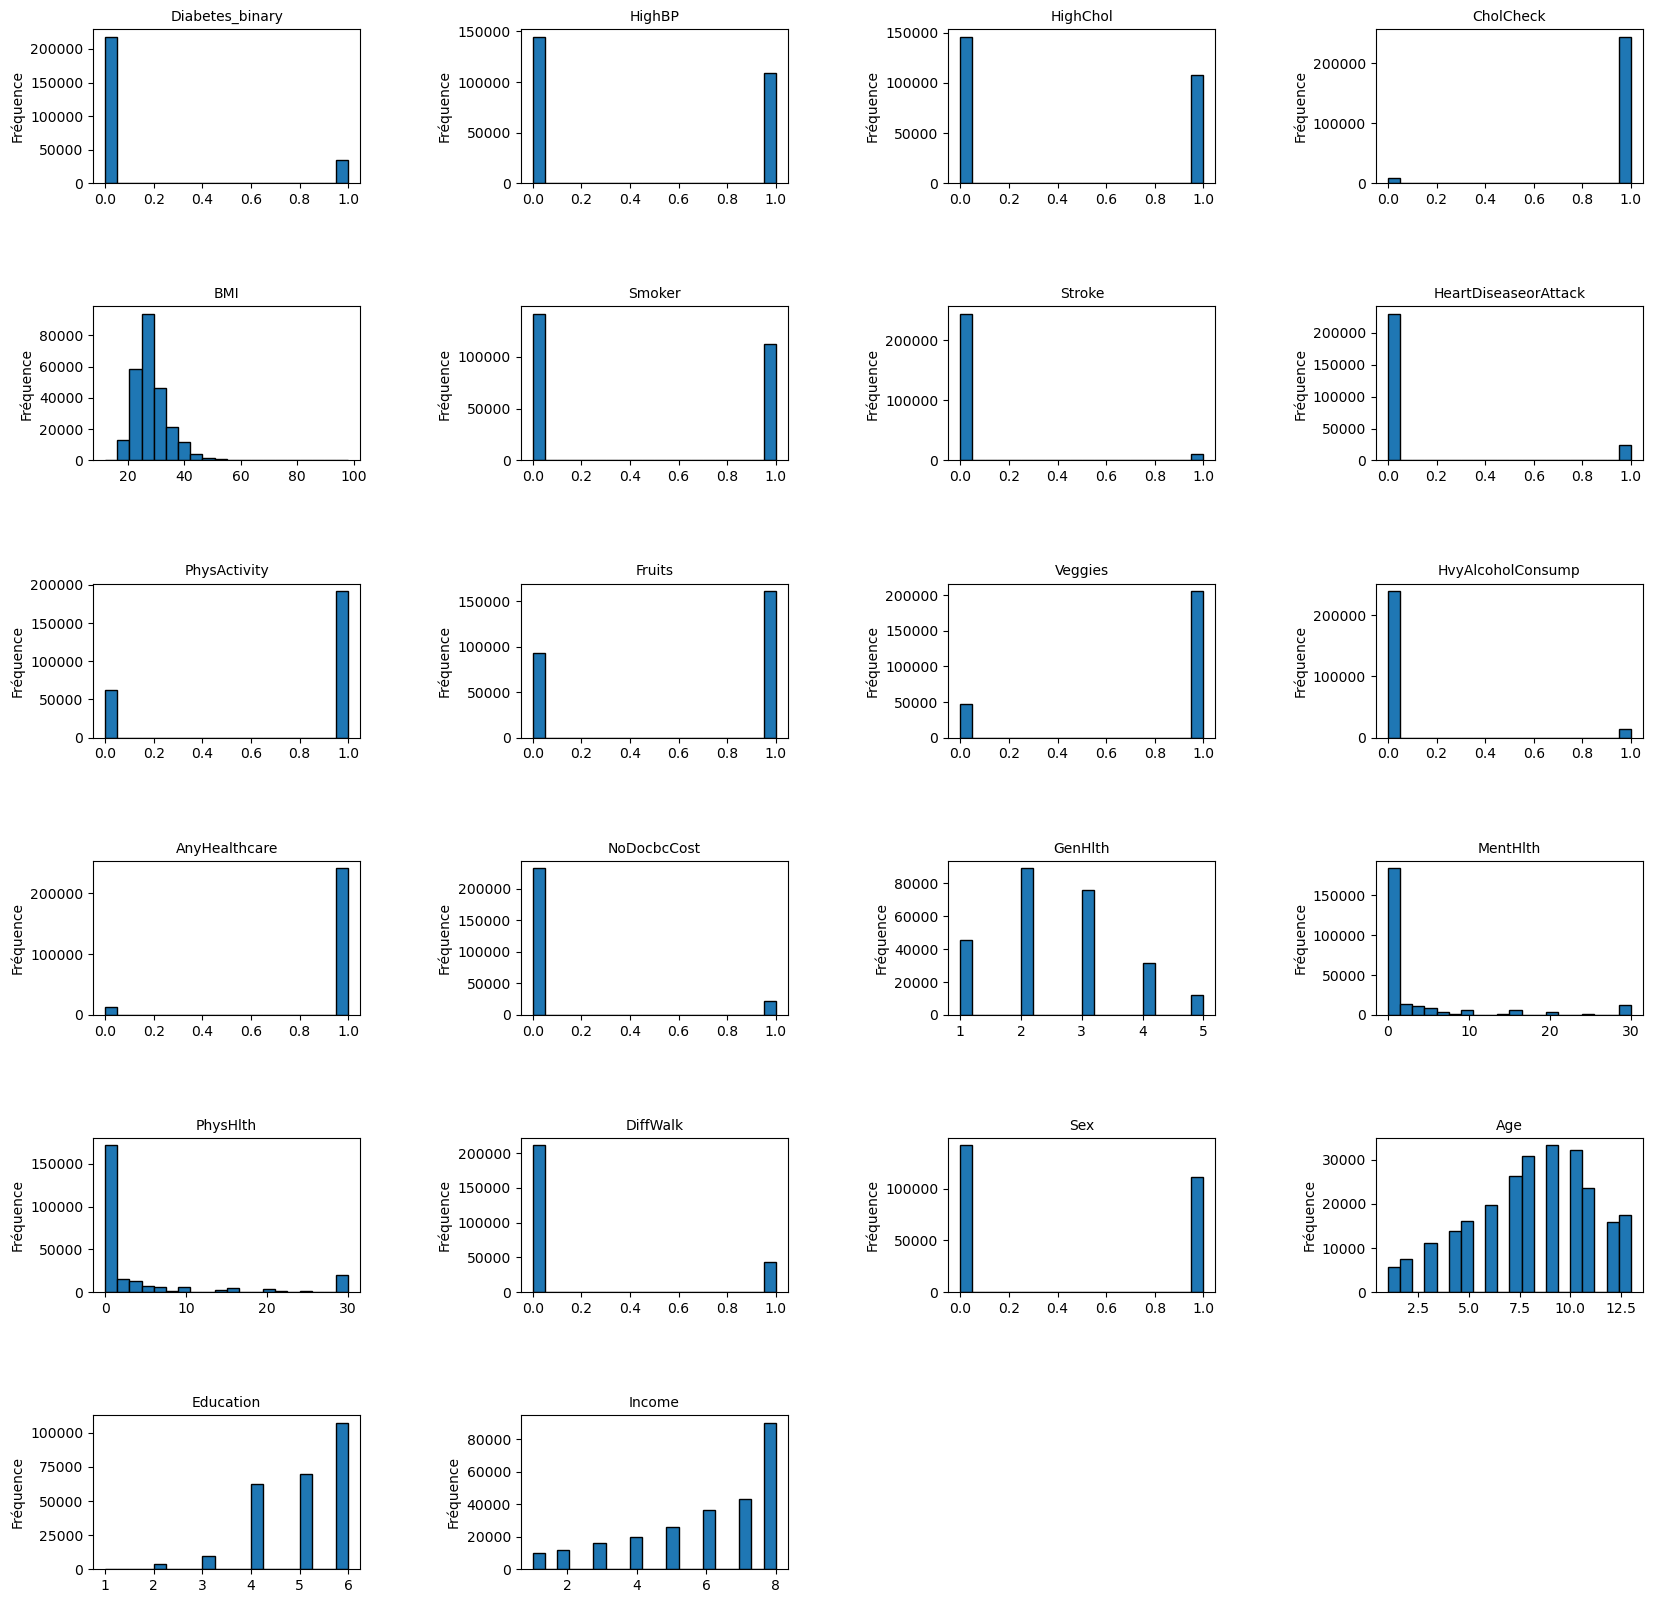

Le pourcentage de diabétique est de 13.933301797540206 %


In [93]:
from src.ml_workflow import load_data_and_description
## Chargement du dataset 
df = load_data_and_description(data_path)

### Premières observations

- Pas de **valeurs manquantes**  pas de complétion nécessaire ( ça on le savait déjà).  
- 22 colonnes, toutes de type **float**.  
- Pas de données bruitées visibles.  
- Environ **250 000 lignes**, ce qui en fait un jeu de données assez volumineux.  
- La proportion de diabétiques est d’environ **14 %**, ce qui montre un **déséquilibre** des classes.  
  donc Il faudra adapter la méthode d’entraînement (pondération, sur-échantillonnage, etc.).  
- On peut également observer certaines proportions via les histogrammes


## Etape 2 : L'analyse des features 

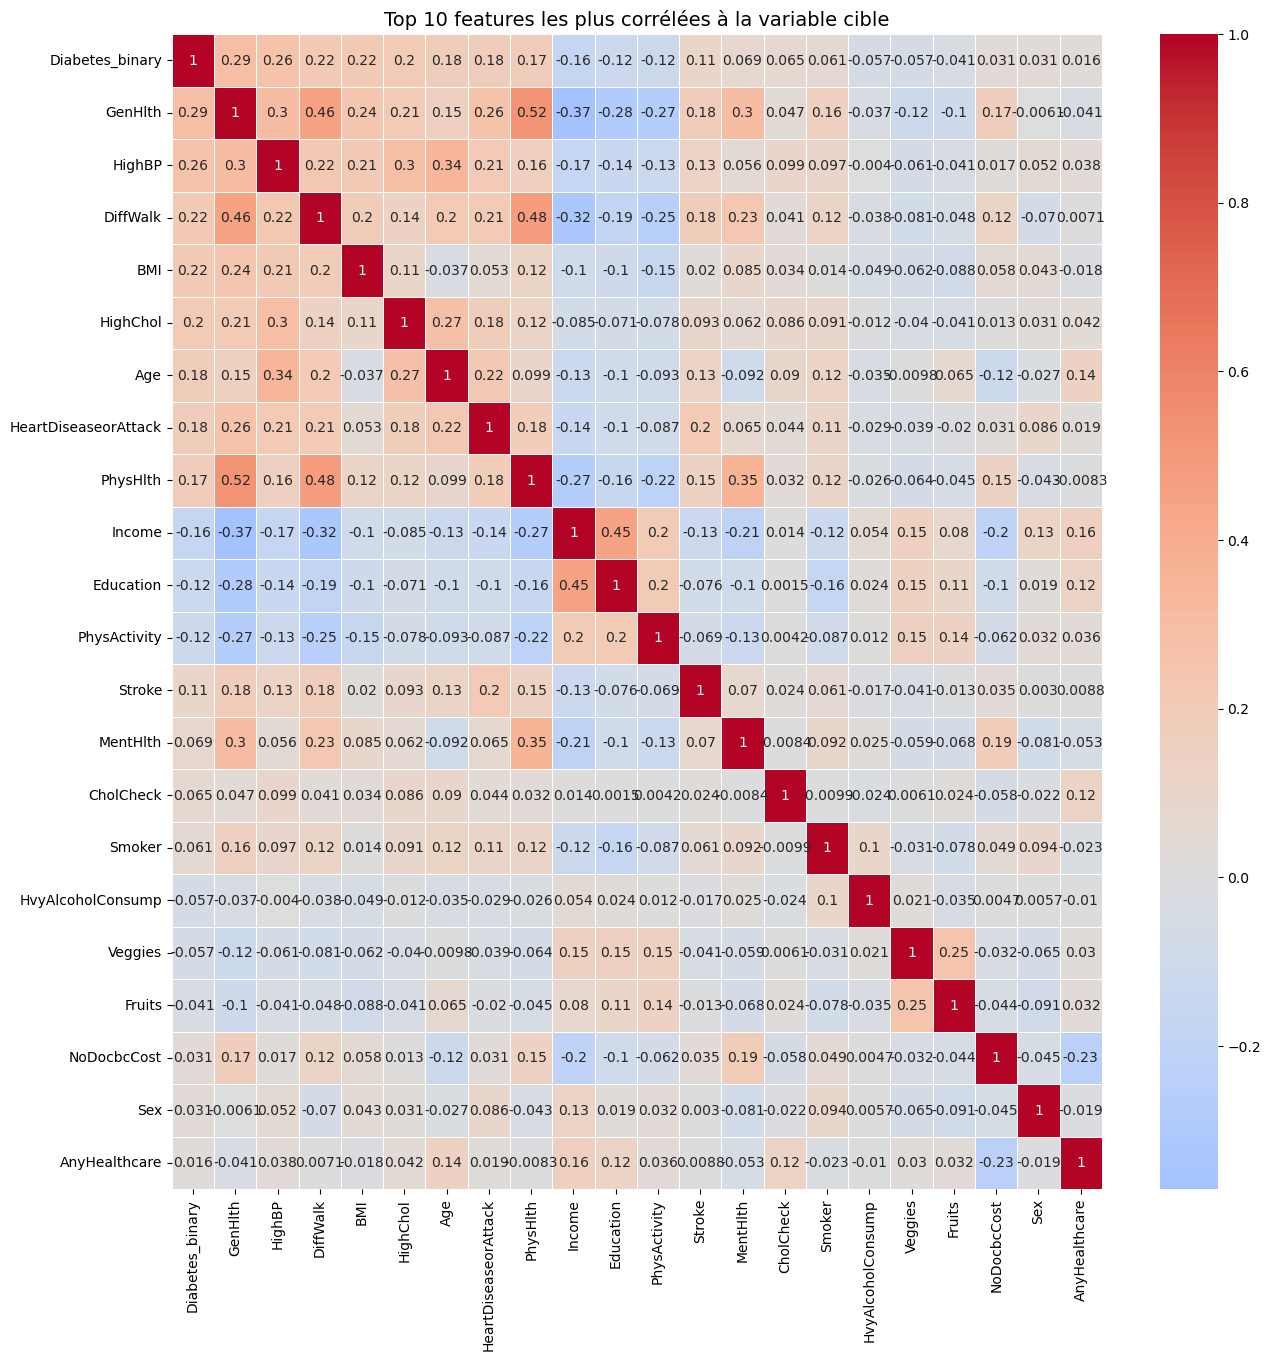

In [41]:
## matrice de corrélation des variables
import seaborn as sns

corr_matrix = df.corr()


# Correlation matrix avec heatmap
top22_features = (
    corr_matrix["Diabetes_binary"].abs().sort_values(ascending=False).head(23).index
)
# Sélection des 10 variables les plus corrélées à la cible
top10_features = (
    corr_matrix["Diabetes_binary"].abs().sort_values(ascending=False).head(11).index
)

plt.figure(figsize=(15, 15))
sns.heatmap(
    corr_matrix.loc[top22_features, top22_features],
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Top 10 features les plus corrélées à la variable cible", fontsize=14)
plt.show()


La matrice de corrélation est de taille 22×22, on va donc se limiter aux 10 features les plus corrélées

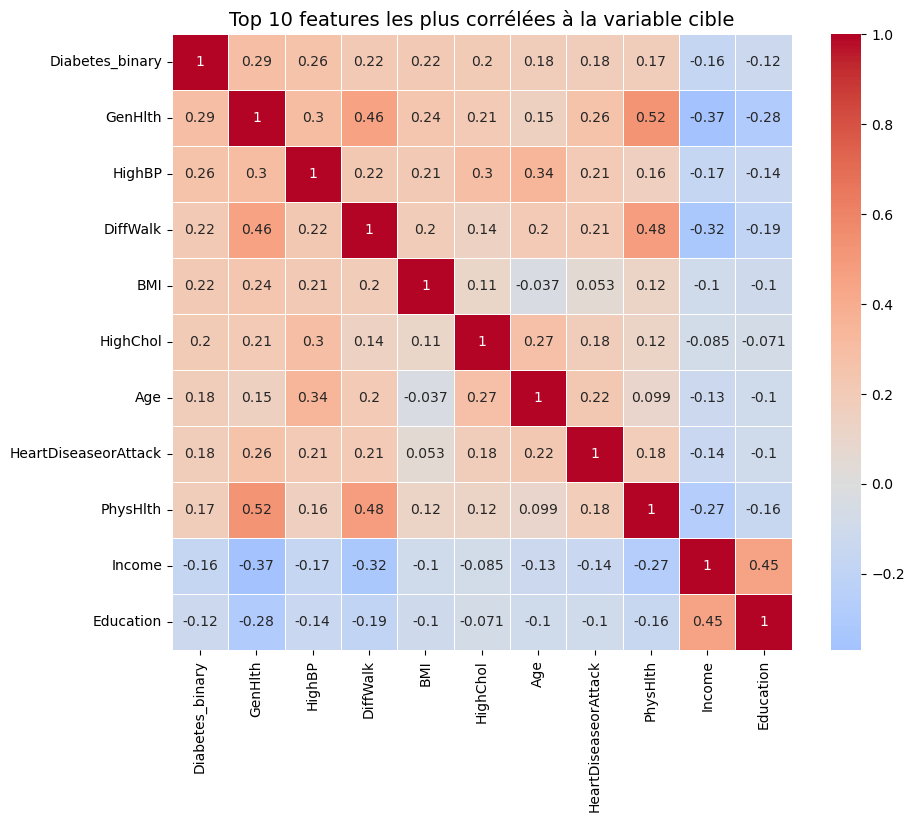

In [94]:
import seaborn as sns

# Sélection des 10 variables les plus corrélées à la cible
top10_features = (
    corr_matrix["Diabetes_binary"].abs().sort_values(ascending=False).head(11).index
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix.loc[top10_features, top10_features],
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Top 10 features les plus corrélées à la variable cible", fontsize=14)
plt.show()


In [95]:
## Pour plus de clarté on affiche le score des 10 paires les plus corrélées

# on extraction des corrélations sous forme de tableau long
corr_pairs = (corr_matrix.unstack().reset_index().rename(columns={"level_0": "Feature1", "level_1": "Feature2", 0: "Correlation"}))

corr_pairs = corr_pairs[corr_pairs["Feature1"] != corr_pairs["Feature2"]]
corr_pairs["AbsCorr"] = corr_pairs["Correlation"].abs()

# Tri par corrélation absolue décroissante
top_corr = corr_pairs.sort_values("AbsCorr", ascending=False).head(10)

print(" Top 10 des paires de variables les plus corrélées (en valeur absolue) :")
display(top_corr)


 Top 10 des paires de variables les plus corrélées (en valeur absolue) :


,Feature1,Feature2,Correlation,AbsCorr
366,PhysHlth,GenHlth,0.524364,0.524364
324,GenHlth,PhysHlth,0.524364,0.524364
390,DiffWalk,PhysHlth,0.478417,0.478417
369,PhysHlth,DiffWalk,0.478417,0.478417
325,GenHlth,DiffWalk,0.456920,0.456920
388,DiffWalk,GenHlth,0.456920,0.456920
482,Income,Education,0.449106,0.449106
461,Education,Income,0.449106,0.449106
329,GenHlth,Income,-0.370014,0.370014
476,Income,GenHlth,-0.370014,0.370014


### Commentaires : 

- La matrice de corrélation montre plusieurs dépendances fortes entre certaines variables (ex. HighBP et HeartDiseaseorAttack).
- Les 10 paires les plus corrélées indiquent une redondance possible entre certains indicateurs de santé.
- On remarque égalment que les 8 premieres sont très corrélées
- Ces observations orienteront la **sélection de features** et la **réduction de dimension** avant entraînement.


### Etape 3 : Reduction de dimension ( PCA ) 
    On fait ça ici pour visualiser les data, et poursuivre l'étape précédente. En revanche elle sera éventuellement pour 
    certains algorithmes 

In [50]:
## La PCA est sensible à l’échelle des variables :
# on veut éviter qu’une feature avec des valeurs grandes (ex : BMI) domine la variance.

from sklearn.preprocessing import StandardScaler

# Séparation des features et de la cible
X = df.drop(columns=["Diabetes_binary"])
y = df["Diabetes_binary"]

# Standardisation (moyenne = 0, variance = 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(" Données standardisées :",
      "Moyenne (approx) :",X_scaled.mean().round(2),
      "et écart-type (approx) :",X_scaled.std().round(2))



 Données standardisées : Moyenne (approx) : 0.0 et écart-type (approx) : 1.0


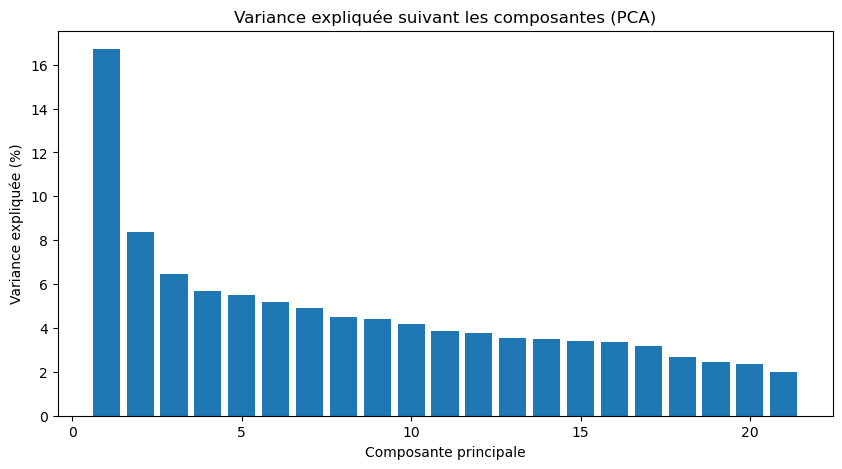

PC1 : 16.71%  |  PC2 : 8.40%
Variance cumulée (PC1+PC2) : 25.11%
PC1 : 16.71%  |  PC2 : 8.40%|  PC3 : 6.48%
Variance cumulée (PC1+PC2+PC3) : 31.59%


In [17]:
## Application de la PCA 

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# on commence avec toutes les composantes
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée par chaque composante via explained_variance_ratio_
explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(10,5))
plt.bar(range(1, len(explained_var) + 1), explained_var * 100)
plt.xlabel("Composante principale")
plt.ylabel("Variance expliquée (%)")
plt.title("Variance expliquée suivant les composantes (PCA)")
plt.show()

# Affiche les 2 premières composantes
print(f"PC1 : {explained_var[0]*100:.2f}%  |  PC2 : {explained_var[1]*100:.2f}%")
print(f"Variance cumulée (PC1+PC2) : {explained_var[:2].sum()*100:.2f}%")

# Affiche les 3 premières composantes
print(f"PC1 : {explained_var[0]*100:.2f}%  |  PC2 : {explained_var[1]*100:.2f}%|  PC3 : {explained_var[2]*100:.2f}%")
print(f"Variance cumulée (PC1+PC2+PC3) : {explained_var[:3].sum()*100:.2f}%")


Commentaire : On remarque qu'ici seule la première composante est prépondérante, les 3 composantes principales capturent ~32% de la variance des variables initiales : c'est peu.

In [96]:
## Plus globalement, fixons la variance à 90% et trouvons le nb optimal de dimensions

pca_90 = PCA(0.90)
X_reduced90 = pca_90.fit_transform(X_scaled)

print(f"Nombre de composantes retenues pour 95% de variance : {pca_90.n_components_}")
print(f"Nombre de features concervées  : {X_reduced90.shape[1]}")


## Si l'on veut concerver 95% de la variance 

pca_95 = PCA(0.95)
X_reduced95 = pca_95.fit_transform(X_scaled)

print(f" Nombre de composantes retenues pour 95% de variance : {pca_95.n_components_}")
print(f"Nombre de features concervées : {X_reduced95.shape[1]}")


Nombre de composantes retenues pour 95% de variance : 17
Nombre de features concervées  : 17
 Nombre de composantes retenues pour 95% de variance : 19
Nombre de features concervées : 19


### Résultats obtenus suite à la PCA : 

Pour expliquer 90% et respectivement 95% de la variance totale, la 
PCA retient 17 et 19 composantes principales selon les réglages effectués.
Autrement dit, la quasi-totalité des dimensions originales sont nécessaires 
pour préserver l’information statistique initiale. Finalement,
les variables du jeu de données sont faiblement redondantes, chacune apporte une contribution spécifique.
On pourrait réduire raisonnablement le nombre de variables de 1 ou 2 sans perdre 
trop d'information ( mais ça ne serait a priori un grand gain sur nos algos lors de l'étape d'entrainement ...)



### Préparation du jeu de donneés et split


In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from src.ml_workflow import split_data

X_train,y_train, X_test,y_test = split_data(df , test_size = 0.2,random_state=42)

Colonne cible utilisée : 'Diabetes_binary'
 Split effectué : 202944 train / 50736 test


### Entrainement des modèles et évaluation 
on choisit comme algorithmes de classification :
   -  Logistic regression 
   -  Random Forest 
   -  XGboost

Deux avantages principaux motive ces choix :

le premier étant que dans sklearn on peut ré-équilibrer le dataSet lorsqu'on 
utilise Logistic regression et Random Forest, sans avaoir à la faire à la main.

L'autre élément qui motive ce choix c'est le fait que ces algos sont dans leur principe assez différents, on peut espérer 
qu'ils fassent des erreurs assez différentes les uns des autres.
On souhaite par la suite faire du bagging et combiner les trois pour utilier 
de la classification par vote, c-à-d une stratégie d'ensemble déjà utiliser 
dans algo de Random Forest sur des arbres de décision. 
On espère ainsi avoir un recall encore meilleur ; voyons ça : 

 

In [101]:
from src.ml_workflow import train_and_evaluate_models

results_df = train_and_evaluate_models(X_train, y_train, X_test, y_test, threshold=0.35)
display(results_df)


ImportError: cannot import name 'train_and_evaluate_models' from 'src.ml_workflow' (c:\IMT\2A\introML\S2_part2\projetML\ml-project-ue-a\src\ml_workflow.py)

### Visualisation des matrices de confusion 

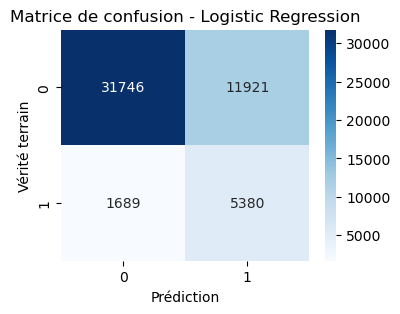

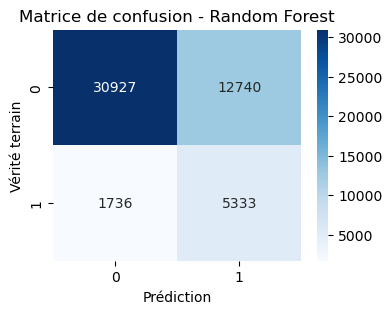

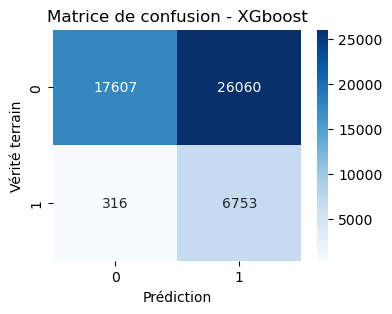

In [ ]:
from src.ml_workflow import plot_confusion_matrices

plot_confusion_matrices(models, X_test, y_test)

### Ajout des courbes Precision/Rappel pour chaque modèle

### Affinage des paramètres avec GridSearchCV ( ou bien Random si c'est trop long )